# "점심"시간대 유동인구 예측

## 1. import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from utils.train_utils import *
warnings.filterwarnings(action='ignore')
path = '../data/train_results/lunch_results/'

## 2. 유동인구의 추세 성분과 주기 성분 결합 (훈련, 검증 데이터)

In [2]:
## cycle result
with open(path + 'l_cycle_results_list.pkl', 'rb') as f:
    cycle_results_list = pickle.load(f)
## trend
with open(path + 'l_trend_results_list.pkl', 'rb') as f:
    trend_results_list = pickle.load(f)
###  scaler
with open('../data/preprocess/scalers.pkl', 'rb') as f:
    sclaers = pickle.load(f)# [m_time_scaler, l_time_scaler, e_time_scaler, no_time_scaler]
time_scaler = sclaers[1]


## 합치기
total_results_list = rescale_data(add_datas(trend_results_list, cycle_results_list), time_scaler)

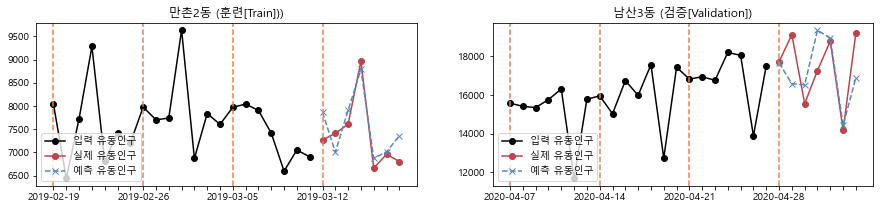

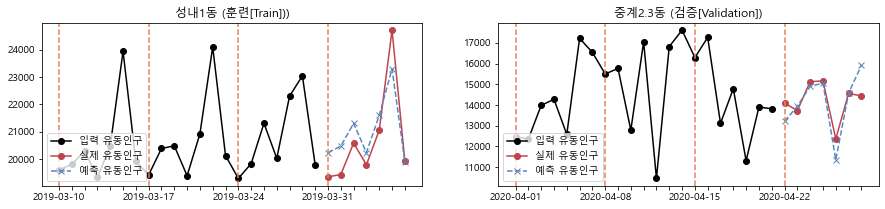

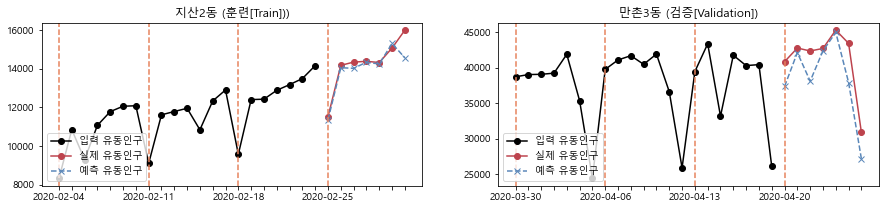

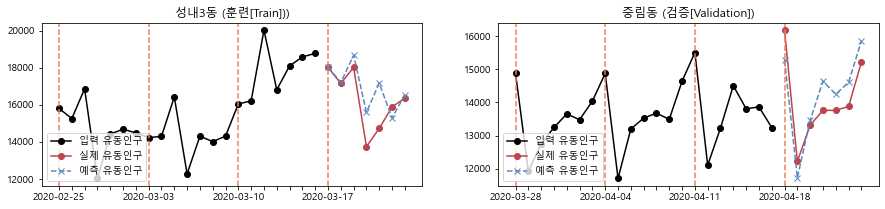

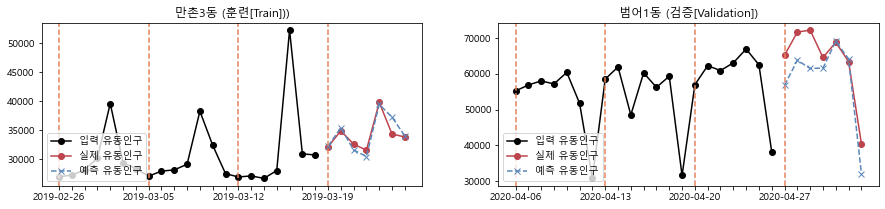

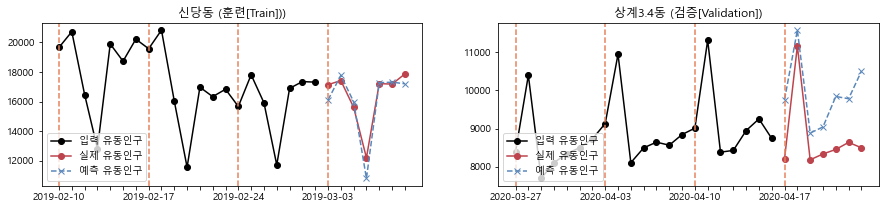

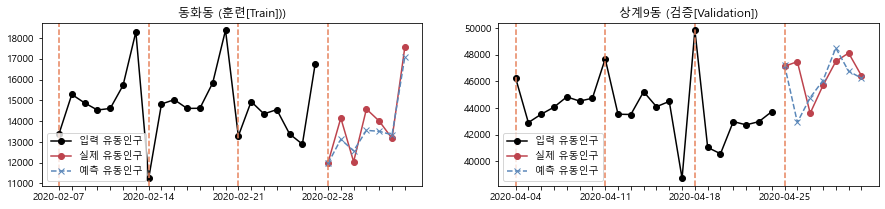

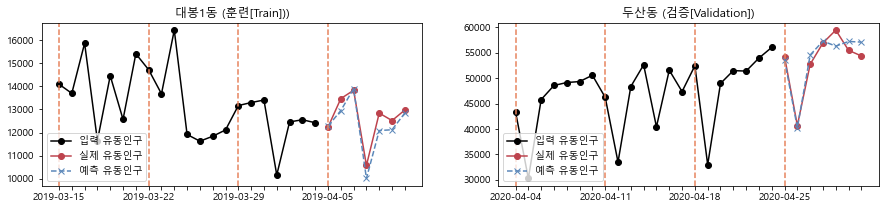

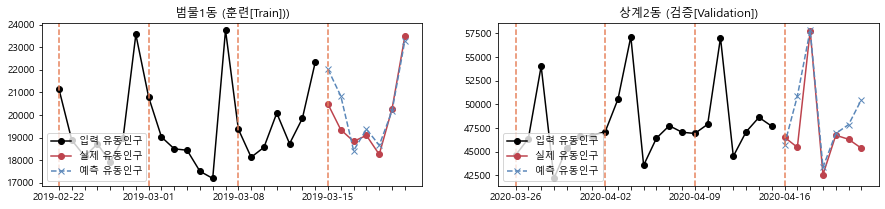

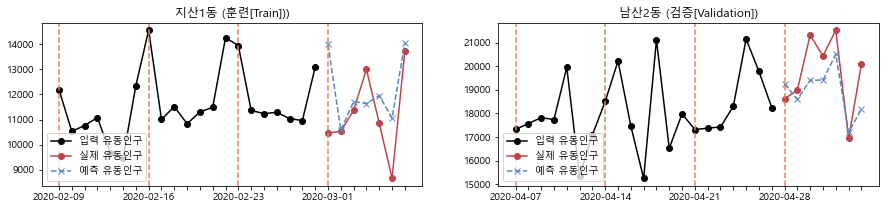

In [3]:
train_x, train_y, train_pred,\
valid_time_x, valid_x, valid_y = total_results_list
plot_predict(train_x, train_y, train_pred,\
                valid_time_x, valid_x, valid_y )
with open(path + 'l_total_results_list.pkl', 'wb') as f:
    pickle.dump(total_results_list, f)            

## 3. 유동인구의 추세 성분과 주기 성분 결합 (평가 데이터)

In [4]:
with open(path + 'l_cycle_results_test.pkl', 'rb') as f:
    m_cycle_results_test = pickle.load(f)
with open(path + 'l_trend_results_test.pkl', 'rb') as f:
    m_trend_results_test = pickle.load(f)
test_input, test_true, test_pred = rescale_data(add_datas(m_cycle_results_test, m_trend_results_test), time_scaler)
test_results = test_input, test_true, test_pred

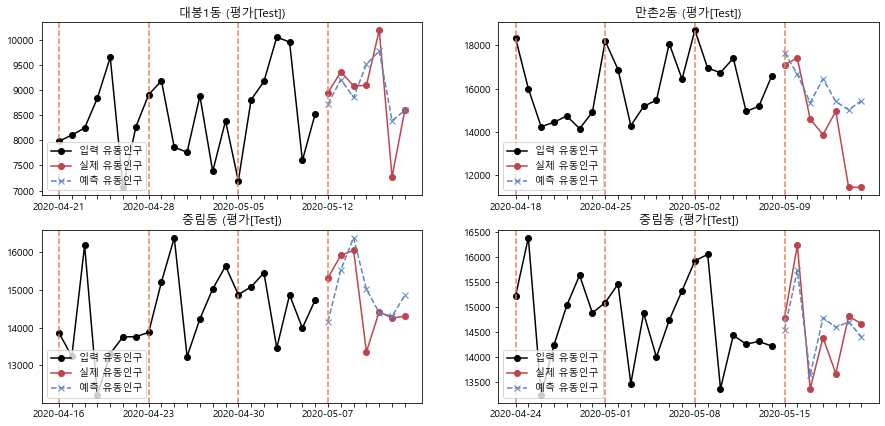

In [5]:
# plot result
plot_test_predict(test_input, test_true, test_pred)
path = '../data/train_results/lunch_results/'
with open(path + 'l_total_results_test.pkl', 'wb') as f:
    pickle.dump(test_results, f)

## 4. 6월 유동인구 예측

### 1) 예측 6월 유동인구 추세(Trend) 성분 주기(Cycle) 성분 결합

In [6]:
### morning scaler
with open('../data/preprocess/scalers.pkl', 'rb') as f:
    sclaers = pickle.load(f)# [m_time_scaler, l_time_scaler, e_time_scaler, no_time_scaler]
time_scaler = sclaers[0]
with open('../data/predict_june/preprocess_june/lunch_june_time.pkl', 'rb') as f:
    time = pickle.load(f)
with open('../data/predict_june/predict_cycle_trend/june_lunch_cycle_pred.pkl', 'rb') as f:
    cycle_pred = pickle.load(f)
with open('../data/predict_june/predict_cycle_trend/june_lunch_trend_pred.pkl', 'rb') as f:
    trend_pred = pickle.load(f)
    
def resize(data, select_col = 0):
    shape = data.shape
    data = time_scaler.inverse_transform(data.reshape(-1), select_col = 0)
    return data.reshape(shape)

pred = trend_pred + cycle_pred
x = time[:,:,-2] + time[:,:,-1]
pred = resize(pred, select_col = 0)
x = resize(x, select_col = 0)

### 2) 상대 지표 생성
    1. 6월에 예측한 유동인구를 동일한 지역에서 과거(30일)과 비교 경우
    2. 6월에 예측한 유동인구를 동일한 날짜 다른 지역(69개)의 유동인구와 비교
         
         0 ~ 100 % Percentile에 대하여 5등급으로 분류 
         
         1단계 : 0 ~ 20 %
         2단계 : 20 ~ 40 %
         3단계 : 40 ~ 60 %
         4단계 : 40 ~ 80 %
         5단계 : 80 ~ 100 %

#### i) 동일한 지역에서 과거(30일)과 비교

In [7]:
nontime = pd.read_csv('../data/original/nontime_data.txt', sep = ' ')
time = pd.read_csv('../data/original/time_data.txt', sep = ' ')
dong_list= time.HDONG_NM.unique()

code_list = [1114065000, 1114061500, 2726066200, 2726061000, 2711067000,
       2726065100, 1114066500, 2726062000, 2726051000, 1135057000,
       2711068000, 1114068000, 2726068000, 1135063000, 1114067000,
       2711069000, 1114055000, 2726053000, 1135070000, 1114059000,
       1135062400, 1135059500, 1135061200, 1114054000, 2711064000,
       1135061100, 1114062500, 2711066000, 1114064500, 2726055000,
       1135069500, 1135072000, 2726056000, 2711054500, 2726064000,
       1135060000, 2726060100, 1135062500, 2726052000, 2726063000,
       2726069000, 2726065200, 2726059000, 2711051700, 2726057000,
       1114052000, 2726066100, 1135067000, 1114060500, 1135066500,
       2726054000, 2711065000, 1135056000, 2726060200, 2726067000,
       1135058000, 2711058500, 1114063500, 1135064000, 2726056100,
       1135062100, 2726058000, 2711056500, 1135061900, 1135071000,
       1114058000, 1114057000, 2711057500, 2711059500]
       
def name2index(dong_name):
    for idx, code in enumerate(code_list):
        if code == time[time.HDONG_NM == dong_name].HDONG_CD.iloc[0]:
            return(idx)


pred_june = pd.DataFrame([pred[name2index(dong)] for dong in dong_list])
pred_june.columns = ['2020-06-01','2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07']
pred_june.index = dong_list
pred_june['AREA'] = [nontime[nontime.HDONG_NM == dong].AREA.iloc[0] for dong in dong_list]
how_insame = pred_june.copy()
how_inother = pred_june.copy()

def find_level(pred, dong_name):
    '''
    0 ~20 : 1 
    20~40 : 2
    40~60 : 3
    60~80 : 4
    80~100: 5
    '''
    # 시간대 상관x
    dist = np.array(time[(time.HDONG_NM == dong_name)&(time.time == 'evening')].flow_pop.iloc[-30:].sort_values())
    for idx, val in enumerate(dist):
        if val > pred:
            break
    if idx == 30-1:
        return 1
    else:
        return int(((idx+1)/30) * 100 // 20) + 1

for dong in dong_list:
    for day in ['2020-06-01','2020-06-02','2020-06-03','2020-06-04','2020-06-05','2020-06-06','2020-06-07']:
        how_insame.loc[dong,day] = find_level(pred_june.loc[dong,day],dong)

#### i) 동일한 날짜에서 다른 지역과 비교

In [8]:
flowperarea = pd.DataFrame({'flowperarea':pred_june.iloc[:,:7].mean(axis = 1)})
for idx, dong in enumerate(dong_list):
    flowperarea.iloc[idx] = flowperarea.iloc[idx] / nontime[nontime.HDONG_NM == dong].AREA.iloc[0] * 100
flowperarea = np.array(flowperarea.flowperarea.sort_values())

def find_level_other(pred, dong_name):
    '''
    0 ~20 : 1 
    20~40 : 2
    40~60 : 3
    60~80 : 4
    80~100: 5
    '''
    for idx, val in enumerate(flowperarea):
        if val > pred:
            break
    if idx == 68:
        return 1
    else:
        return int(((idx+1)/69) * 100 // 20) + 1
how_inother = pred_june.copy()
for dong in dong_list:
    for day in ['2020-06-01','2020-06-02','2020-06-03','2020-06-04','2020-06-05','2020-06-06','2020-06-07']:
        how_inother.loc[dong,day] = find_level_other(how_inother.loc[dong,day] / how_inother.loc[dong,"AREA"] * 100, dong)

In [9]:
how_insame.to_csv('../data/predict_june/result_june/lunch_insame.csv')
how_inother.to_csv('../data/predict_june/result_june/lunch_inother.csv')

In [11]:
print("점심")
display(how_insame.loc[['중림동','소공동','회현동']])
display(how_inother.loc[['중림동','소공동','회현동']])

점심


,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,AREA
중림동,1.0,1.0,1.0,1.0,1.0,1.0,1.0,482329.92
소공동,3.0,3.0,3.0,3.0,4.0,3.0,3.0,893419.62
회현동,1.0,5.0,1.0,1.0,1.0,1.0,3.0,847351.57


,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,AREA
중림동,3.0,3.0,3.0,3.0,3.0,3.0,2.0,482329.92
소공동,5.0,5.0,5.0,5.0,5.0,5.0,5.0,893419.62
회현동,1.0,1.0,1.0,1.0,1.0,1.0,1.0,847351.57
